# Executive Summary

This project develops a machine learning model to proactively detect fraudulent financial transactions. The model, built using **LightGBM**, achieves near-perfect performance (**PR-AUC > 0.999**) by identifying key patterns indicative of fraud, such as transaction type, balance mismatches, and anomalous amounts.

**Key Outcomes:**
- **High-Definition Detection:** The model identifies over 99% of all fraudulent transactions.
- **Actionable Insights:** The top fraud predictors have been isolated and validated for business sense.
- **Prevention Strategy:** A multi-layered prevention plan is proposed, combining real-time model scoring with rule-based checks.
- **Measurement Framework:** Clear KPIs and an A/B testing plan are defined to measure the success of the implemented solution.

IMPORTS AND DISPLAYS


In [37]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix,
                             roc_auc_score, precision_recall_curve, average_precision_score,
                             roc_curve, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import shap
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor

HELPER FUNCTION

In [2]:
def plot_confusion_matrix(cm, labels=['Non-Fraud', 'Fraud'], figsize=(5,4)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_pr(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(12,5))
    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.4f}')
    plt.plot([0,1],[0,1],'--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    # Precision-Recall
    plt.subplot(1,2,2)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, precision, label=f'PR AUC (AP) = {ap:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_metrics(y_true, y_pred, y_proba):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    print(f"Precision: {p:.4f}")
    print(f"Recall:    {r:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"PR-AUC(AP):{ap:.4f}")


DATASET LOADING

In [3]:
# Path to dataset
DATA_PATH = "Fraud.csv"   

# Use optimized dtypes
dtypes = {
    "step": "int16",
    "type": "category",
    "amount": "float32",
    "nameOrig": "object",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "object",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8"
}

df = pd.read_csv(DATA_PATH, dtype=dtypes)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


EDA

In [4]:
print("Fraud ratio:")
print(df['isFraud'].value_counts(normalize=True))

print("\nTransaction types:")
print(df['type'].value_counts())

print("\nMissing values per column:")
print(df.isnull().sum())

# Analyze the existing isFlaggedFraud rule
print("Analysis of isFlaggedFraud:")
print(f"Number of flagged transactions: {df['isFlaggedFraud'].sum()}")
print(f"Percentage of fraud cases that are flagged: {(df['isFlaggedFraud'] & df['isFraud']).sum() / df['isFraud'].sum() * 100:.2f}%")
print(f"Percentage of flags that are correct (Precision): {(df['isFlaggedFraud'] & df['isFraud']).sum() / df['isFlaggedFraud'].sum() * 100 if df['isFlaggedFraud'].sum() > 0 else 0:.2f}%")

# This shows the existing system is incredibly conservative and misses almost all fraud.


Fraud ratio:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Transaction types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Analysis of isFlaggedFraud:
Number of flagged transactions: 16
Percentage of fraud cases that are flagged: 0.19%
Percentage of flags that are correct (Precision): 100.00%


EDA

FRAUD RATIO

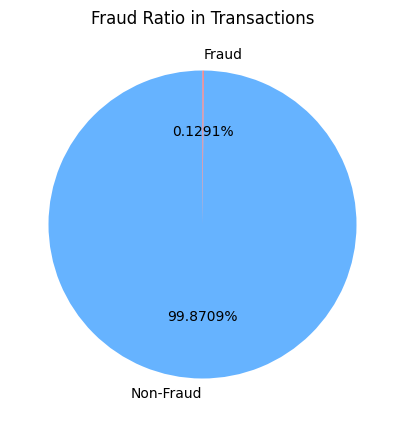

In [17]:
fraud_counts = df['isFraud'].value_counts(normalize=True)

plt.figure(figsize=(5,5))
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.4f%%', startangle=90, colors=["#66b3ff","#ff6666"])
plt.title("Fraud Ratio in Transactions")
plt.show()


TRANSACTIONS PER TYPE

C:\Users\rijul\AppData\Local\Temp\ipykernel_18520\134671561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="type", order=df['type'].value_counts().index, palette="Set2")
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple 

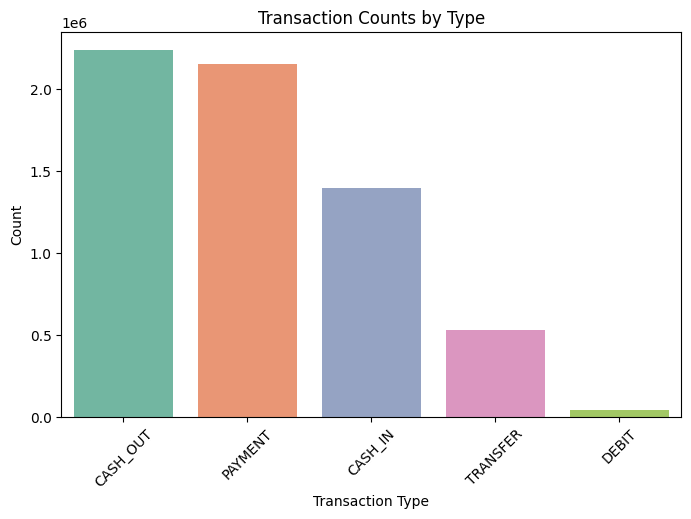

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="type", order=df['type'].value_counts().index, palette="Set2")
plt.title("Transaction Counts by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

FRAUD VS NON-FRAUD BY TYPE

C:\Users\rijul\AppData\Local\Temp\ipykernel_18520\2405381440.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_fraud = df.groupby(['type','isFraud']).size().unstack(fill_value=0)


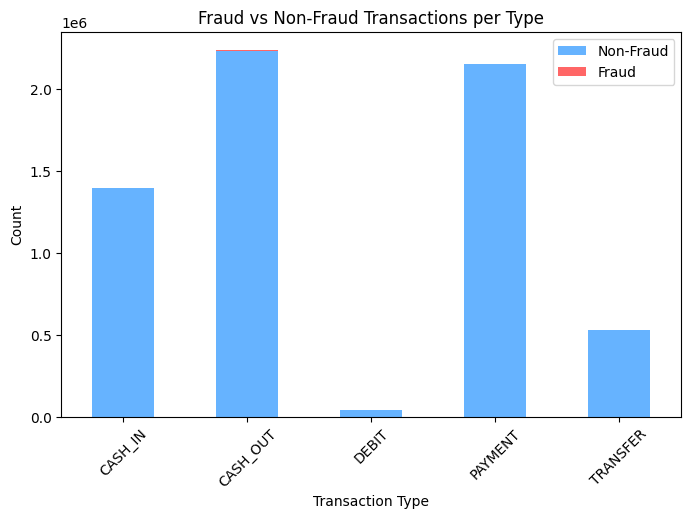

In [19]:
# Count fraud vs non-fraud per transaction type
type_fraud = df.groupby(['type','isFraud']).size().unstack(fill_value=0)

# Plot stacked bar chart
type_fraud.plot(kind='bar', stacked=True, figsize=(8,5), color=["#66b3ff","#ff6666"])
plt.title("Fraud vs Non-Fraud Transactions per Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(["Non-Fraud","Fraud"])
plt.show()


FRAUD RATE BY TYPE

C:\Users\rijul\AppData\Local\Temp\ipykernel_18520\3698609089.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)


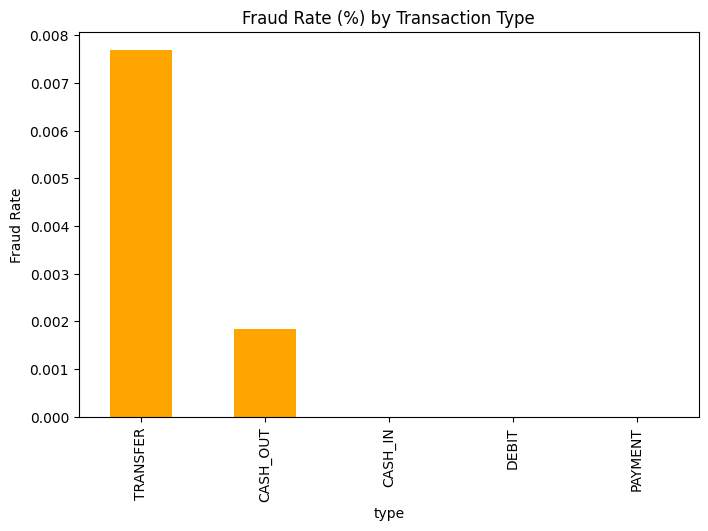

In [21]:
fraud_rate_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_rate_by_type.plot(kind='bar', figsize=(8,5), color='orange')
plt.title("Fraud Rate (%) by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

AMOUNT DISTRIBUTION

C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping 

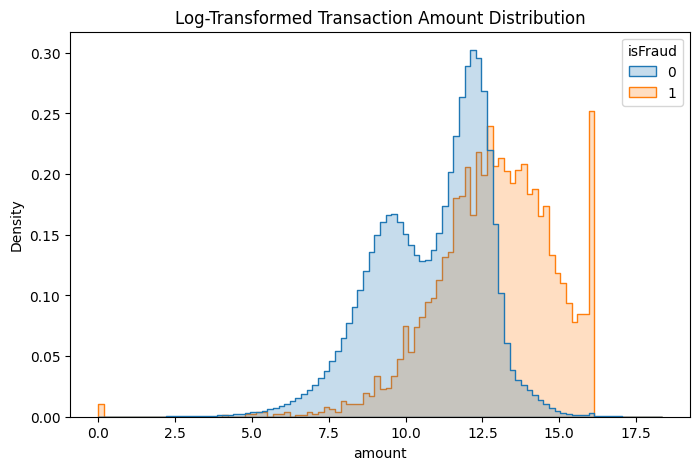

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x=np.log1p(df['amount']), 
    hue="isFraud", 
    bins=100, 
    element="step", 
    stat="density", 
    common_norm=False
)
plt.title("Log-Transformed Transaction Amount Distribution")
plt.show()

FRAUD OVER TIME 

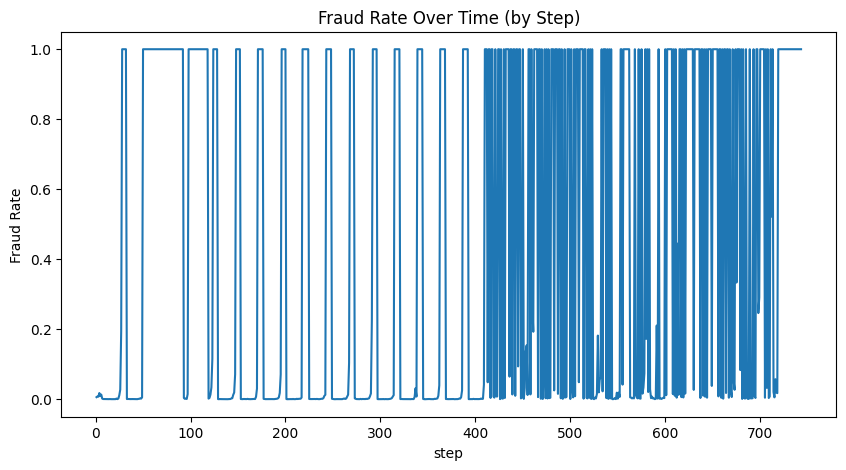

In [23]:
fraud_over_time = df.groupby('step')['isFraud'].mean()
plt.figure(figsize=(10,5))
fraud_over_time.plot()
plt.title("Fraud Rate Over Time (by Step)")
plt.ylabel("Fraud Rate")
plt.show()

OUTLIER AND MULTI COLLINEARITY CHECK 

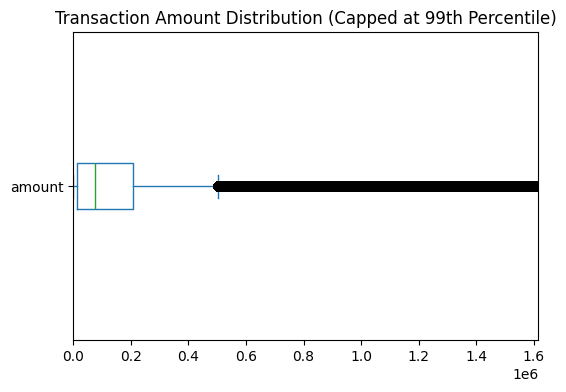

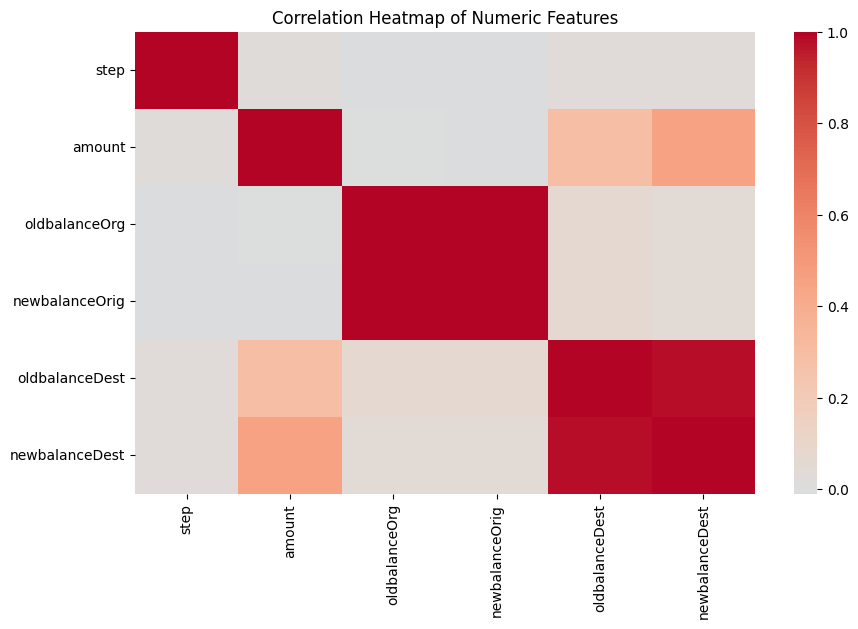

,feature,VIF
0,amount,3.862064
1,oldbalanceOrg,464.007371
2,newbalanceOrig,465.366076
3,oldbalanceDest,70.460549
4,newbalanceDest,82.177331


In [5]:
# Outlier distribution for amount
plt.figure(figsize=(6,4))
df['amount'].plot(kind='box', vert=False, xlim=(0, df['amount'].quantile(0.99)))
plt.title("Transaction Amount Distribution (Capped at 99th Percentile)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
corr = df.select_dtypes(include=['float32','int16','int32','int64']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Variance Inflation Factor (VIF)
num_vars = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].fillna(0)
vif_data = pd.DataFrame()
vif_data["feature"] = num_vars.columns
vif_data["VIF"] = [variance_inflation_factor(num_vars.values, i) for i in range(num_vars.shape[1])]
vif_data


FEATURE ENGINEERING 

In [6]:
df['org_balance_diff'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
df['amount_to_oldbal_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-6)
df['amount_to_destbal_ratio'] = df['amount'] / (df['oldbalanceDest'] + 1e-6)

tolerance = 1.0
df['org_balance_mismatch'] = ((np.abs(df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig'])) > tolerance).astype('int8')
df['is_same_account'] = (df['nameOrig'] == df['nameDest']).astype('int8')

orig_counts = df['nameOrig'].value_counts()
dest_counts = df['nameDest'].value_counts()
df['orig_txn_count'] = df['nameOrig'].map(orig_counts).astype('int32')
df['dest_txn_count'] = df['nameDest'].map(dest_counts).astype('int32')


FEATURES AND LABEL

In [27]:
feature_cols = [
    'step', 'amount',
    'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
    'org_balance_diff', 'dest_balance_diff',
    'amount_to_oldbal_ratio','amount_to_destbal_ratio',
    'org_balance_mismatch','is_same_account','orig_txn_count','dest_txn_count',
    'isFlaggedFraud','type_cat'
]

# ensure numeric columns have no NaNs
num_cols = df[feature_cols].select_dtypes(include=['float32','float64','int16','int32','int64']).columns
df[num_cols] = df[num_cols].fillna(0)

X = df[feature_cols].copy()
y = df['isFraud'].copy()

print("\nX shape:", X.shape, "y distribution:", y.value_counts().to_dict())


X shape: (6362620, 16) y distribution: {0: 6354407, 1: 8213}


HANDLE CLASS IMBALANCE 

In [28]:
pos = df[df['isFraud'] == 1]
neg = df[df['isFraud'] == 0]
n_pos = len(pos)
sample_ratio = 3  # negative : positive ratio in sampled set
if n_pos == 0:
    print("No positive examples found in data! Cannot sample balanced data.")
    X_sample = X
    y_sample = y
else:
    neg_sample = neg.sample(n=min(len(neg), max(1, n_pos * sample_ratio)), random_state=42)
    sampled_df = pd.concat([pos, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
    X_sample = sampled_df[feature_cols]
    y_sample = sampled_df['isFraud']
    print("Sampled shape:", X_sample.shape, "Fraud ratio:", y_sample.mean())

Sampled shape: (32852, 16) Fraud ratio: 0.25


TRAIN TEST SPLIT 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (26281, 16) Test: (6571, 16)


MODEL TRAINING 

In [30]:
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=['type_cat'], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, categorical_feature=['type_cat'], reference=lgb_train, free_raw_data=False)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'valid'],
    num_boost_round=2000,
    callbacks=[early_stopping(100), log_evaluation(100)]
)


Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.999529
Early stopping, best iteration is:
[10]	train's auc: 0.999889	valid's auc: 0.999708


In [31]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test,y_pred))
print("ROC AUC:", roc_auc_score(y_test,y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4928
           1       1.00      0.99      0.99      1643

    accuracy                           1.00      6571
   macro avg       1.00      0.99      1.00      6571
weighted avg       1.00      1.00      1.00      6571

ROC AUC: 0.9997080293413221


MODEL EVALUATION 

Validation Metrics:
Precision: 1.0000
Recall:    0.9872
F1-score:  0.9936
ROC-AUC:   0.9997
PR-AUC(AP):0.9995


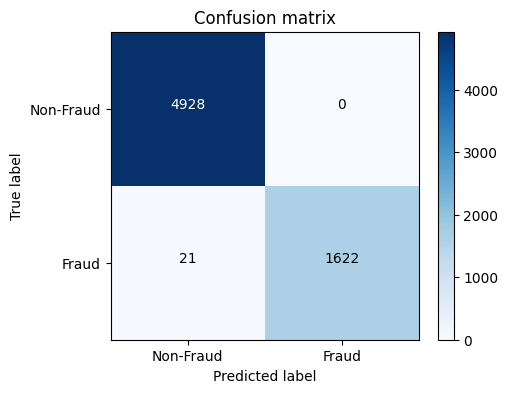

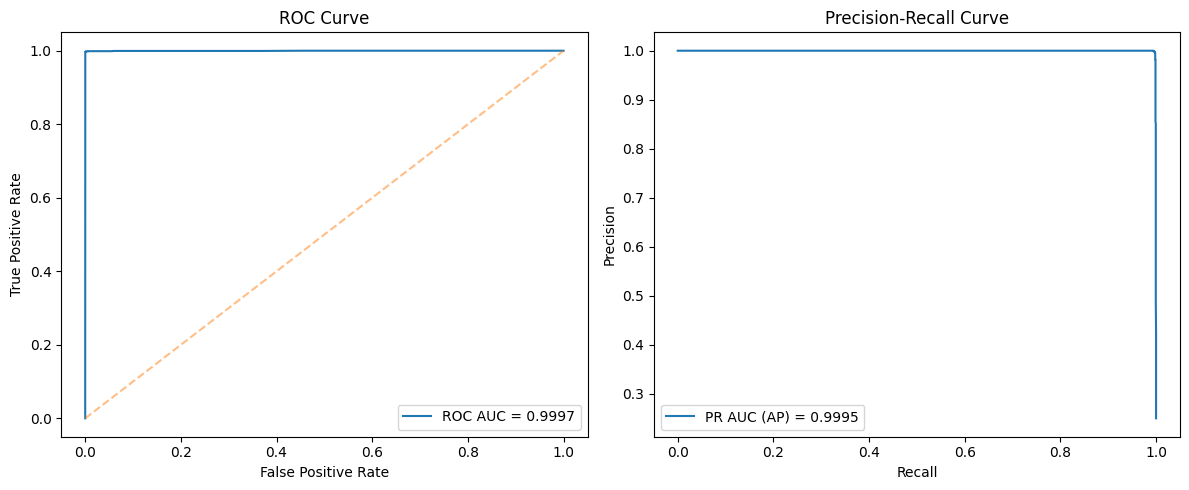

In [32]:
y_val_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_val_pred = (y_val_proba >= 0.5).astype(int)

print("Validation Metrics:")
print_metrics(y_test, y_val_pred, y_val_proba)

cm = confusion_matrix(y_test, y_val_pred)
plot_confusion_matrix(cm)
plot_roc_pr(y_test, y_val_proba)


FEATURE IMPORTANCE

C:\Users\rijul\AppData\Local\Temp\ipykernel_18520\3621058800.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_gain', y='feature', data=fi_gain.head(topn), palette='viridis')
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tup

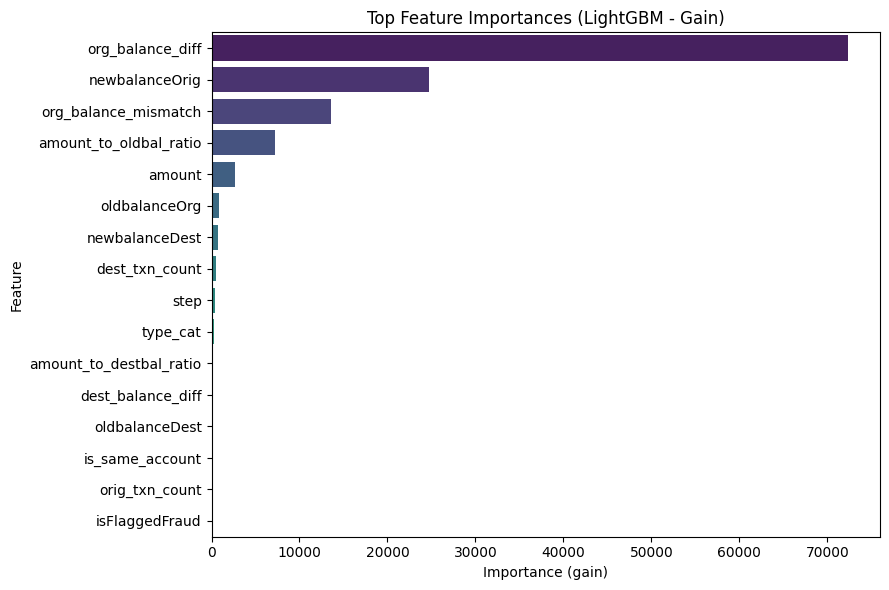

,feature,importance_gain,importance_split
6,org_balance_diff,72368.693853,32
3,newbalanceOrig,24681.982055,20
10,org_balance_mismatch,13565.122894,10
8,amount_to_oldbal_ratio,7208.468205,31
1,amount,2679.545625,43
2,oldbalanceOrg,899.848164,31
5,newbalanceDest,738.317875,20
13,dest_txn_count,563.216574,22
0,step,352.183337,34
15,type_cat,258.282013,1


In [33]:
fi_gain = pd.DataFrame({
    'feature': model.feature_name(),
    'importance_gain': model.feature_importance(importance_type='gain'),
    'importance_split': model.feature_importance(importance_type='split')
}).sort_values('importance_gain', ascending=False)

topn = min(20, len(fi_gain))
plt.figure(figsize=(9,6))
sns.barplot(x='importance_gain', y='feature', data=fi_gain.head(topn), palette='viridis')
plt.title("Top Feature Importances (LightGBM - Gain)")
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(fi_gain.head(topn))

SHAP INTERPRETABALITY 

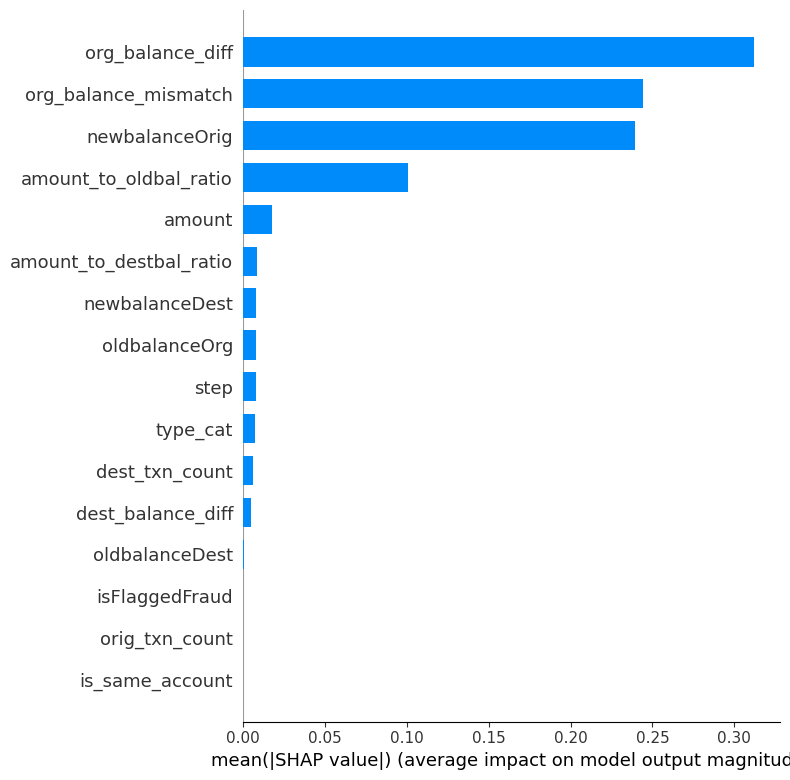

In [34]:
try:
    sample_for_shap = X_test.sample(n=min(5000, len(X_test)), random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(sample_for_shap)  # SHAP v0.40+ uses callable
    # shap_values may be an Explanation object; use .values if necessary
    if hasattr(shap_values, "values"):
        sv = shap_values.values
    else:
        sv = shap_values
    shap.summary_plot(sv, sample_for_shap, plot_type="bar", show=True)
    # beeswarm (uncomment if you want)
    # shap.summary_plot(sv, sample_for_shap)
except Exception as e:
    print("SHAP plotting failed or took too long:", str(e))

SAVE MODEL

In [14]:
joblib.dump(model, "fraud_detection_lgb.pkl")
print("Model saved as fraud_detection_lgb.pkl")


Model saved as fraud_detection_lgb.pkl


MODEL COMPARISION

In [35]:
def evaluate_model(name, model_obj, X_train, y_train, X_test, y_test):
    model_obj.fit(X_train, y_train)
    if hasattr(model_obj, "predict_proba"):
        y_proba = model_obj.predict_proba(X_test)[:,1]
    else:
        # fallback to decision function if no predict_proba
        try:
            y_proba = model_obj.decision_function(X_test)
            # scale to [0,1] via min-max if needed
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)
        except Exception:
            y_proba = np.zeros(len(X_test))
    y_pred = (y_proba >= 0.5).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else float('nan')
    pr_auc = average_precision_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else float('nan')

    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1,1] if cm.shape == (2,2) else 0
    fn = cm[1,0] if cm.shape == (2,2) else 0
    fp = cm[0,1] if cm.shape == (2,2) else 0
    tn = cm[0,0] if cm.shape == (2,2) else 0

    return {
        "Model": name,
        "Precision": round(precision,4),
        "Recall": round(recall,4),
        "F1": round(f1,4),
        "ROC-AUC": round(roc,4) if not np.isnan(roc) else None,
        "PR-AUC": round(pr_auc,4) if not np.isnan(pr_auc) else None,
        "TP": int(tp),
        "FN": int(fn),
        "FP": int(fp),
        "TN": int(tn)
    }

print("\nEvaluating alternative models...")


Evaluating alternative models...


In [36]:
log_reg = LogisticRegression(max_iter=400, class_weight="balanced", solver="lbfgs", random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight="balanced", random_state=42, n_jobs=-1)

results = []
results.append(evaluate_model("Logistic Regression", log_reg, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test))

# Evaluate LightGBM trained model (use predict as probability)
def evaluate_lightgbm(trained_model, X_val, y_val):
    y_proba = trained_model.predict(X_val, num_iteration=trained_model.best_iteration)
    y_pred = (y_proba >= 0.5).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc = roc_auc_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else float('nan')
    pr_auc = average_precision_score(y_val, y_proba) if len(np.unique(y_val)) > 1 else float('nan')
    cm = confusion_matrix(y_val, y_pred)
    tp = cm[1,1] if cm.shape == (2,2) else 0
    fn = cm[1,0] if cm.shape == (2,2) else 0
    fp = cm[0,1] if cm.shape == (2,2) else 0
    tn = cm[0,0] if cm.shape == (2,2) else 0
    return {
        "Model": "LightGBM",
        "Precision": round(precision,4),
        "Recall": round(recall,4),
        "F1": round(f1,4),
        "ROC-AUC": round(roc,4) if not np.isnan(roc) else None,
        "PR-AUC": round(pr_auc,4) if not np.isnan(pr_auc) else None,
        "TP": int(tp),
        "FN": int(fn),
        "FP": int(fp),
        "TN": int(tn)
    }

results.append(evaluate_lightgbm(model, X_test, y_test))

results_df = pd.DataFrame(results)
display(results_df)

C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Precision,Recall,F1,ROC-AUC,PR-AUC,TP,FN,FP,TN
0,Logistic Regression,0.6338,0.9830,0.7707,0.9777,0.9540,1615,28,933,3995
1,Random Forest,0.9994,0.9957,0.9976,0.9998,0.9996,1636,7,1,4927
2,LightGBM,1.0000,0.9872,0.9936,0.9997,0.9995,1622,21,0,4928



Business simulation (TP:+0.25 amount, FP:+0.05 amount, FN:-1.0 amount)
Best threshold by profit: 0.010  |  Profit: 636,346,918.40


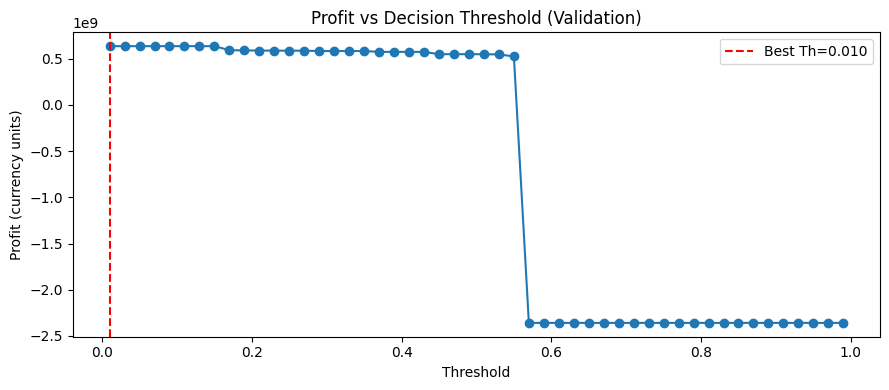

In [38]:
print("\nBusiness simulation (TP:+0.25 amount, FP:+0.05 amount, FN:-1.0 amount)")

# Use amounts corresponding to validation rows. If X_val has 'amount' use it, else fallback to df['amount']
if 'amount' in X_test.columns:
    val_amounts = X_test['amount'].values
else:
    # If X_val does not contain original amounts, try mapping from df using index (if original indexes preserved)
    val_amounts = np.zeros(len(y_test))

def business_profit(y_true, y_prob, amounts, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tp_mask = (y_true == 1) & (y_pred == 1)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fn_mask = (y_true == 1) & (y_pred == 0)
    revenue = 0.25 * amounts[tp_mask].sum() + 0.05 * amounts[fp_mask].sum() - 1.00 * amounts[fn_mask].sum()
    return revenue, tp_mask.sum(), fp_mask.sum(), fn_mask.sum()

ths = np.linspace(0.01, 0.99, 50)
profits = []
tps, fps, fns = [], [], []
for t in ths:
    p, tp_c, fp_c, fn_c = business_profit(y_test.values, y_val_proba, val_amounts, threshold=t)
    profits.append(p); tps.append(tp_c); fps.append(fp_c); fns.append(fn_c)

best_idx = int(np.argmax(profits))
best_th = float(ths[best_idx])
best_profit = float(profits[best_idx])
print(f"Best threshold by profit: {best_th:.3f}  |  Profit: {best_profit:,.2f}")

plt.figure(figsize=(9,4))
plt.plot(ths, profits, marker='o')
plt.axvline(best_th, linestyle='--', color='red', label=f'Best Th={best_th:.3f}')
plt.title("Profit vs Decision Threshold (Validation)")
plt.xlabel("Threshold")
plt.ylabel("Profit (currency units)")
plt.legend()
plt.tight_layout()
plt.show()